In [21]:
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances
from scipy.spatial import distance
import matplotlib.pyplot as plt
import math
from scipy.spatial.distance import pdist 
import os

# from lenskit.datasets import ML100K, MovieLens
# from lenskit.algorithms import Recommender, als
# from lenskit import batch, topn


import trecs
from trecs.models import ImplicitMF, ImplicitMFLFD, ContentFiltering
from trecs.random import Generator
from trecs.metrics import MSEMeasurement, AverageFeatureScoreRange, RecSimilarity, InteractionSimilarity, Measurement
from trecs.components import Users
import trecs.matrix_ops as mo


In [3]:
# basically just recommends items based on the estimates of user preferences!
# this will form the basis of our "ideal" recommender
class IdealRecommender(ContentFiltering):
    def _update_internal_state(self, interactions):
        # do not change users_hat! 
        pass
    
    def process_new_items(self, new_items):
        """
        Generate zero attributes for new items. Remember,
        this doesn't actually matter because the IdealRecommender
        uses its perfect score function, not
        """
        num_items = new_items.shape[1]
        num_attr = self.items_hat.shape[0]
        item_representation = GENERATOR.random((num_attr, num_items))
        return item_representation

# random recommender - randomly update users at every step
class RandomRecommender(ContentFiltering):
    def _update_internal_state(self, interactions):
        self.items_hat[:, :] = GENERATOR.random(self.items_hat.shape)
        self.users_hat[:, :] = GENERATOR.random(self.users_hat.shape)
        
    def process_new_items(self, new_items):
        """
        Generate random attributes for new items.
        """
        num_items = new_items.shape[1]
        num_attr = self.items_hat.shape[0]
        item_representation = GENERATOR.random((num_attr, num_items))
        return item_representation

In [4]:
class ShownMedianPrediction(Measurement):
    """
    Measures the median predicted value of recommended items.

    TODO Description

    This class inherits from :class:`.Measurement`.

    Parameters
    -----------

        verbose: bool (optional, default: False)
            If True, enables verbose mode. Disabled by default.

    Attributes
    -----------
        Inherited by Measurement: :class:`.Measurement`

        name: str (optional, default: "afsr")
            Name of the measurement component.
    """

    def __init__(self, name="shown_median_prediction", verbose=False):
        Measurement.__init__(self, name, verbose, init_value=None)

    def measure(self, recommender, **kwargs):
        """
        Measures the mean of the distance between all pairwise distances between recommendations

        Parameters
        ------------
            recommender: :class:`~models.recommender.BaseRecommender`
                Model that inherits from
                :class:`~models.recommender.BaseRecommender`.

            **kwargs
                Keyword arguments, one of which must be `items_shown`, a |U| x
                num_items_per_iter matrix that contains the indices of every
                item shown to every user at a particular timestep.
        """
        items_shown = kwargs.pop("items_shown", None)
        predicted_shown_vals=recommender.predicted_scores.value[np.expand_dims(np.arange(recommender.predicted_scores.value.shape[0]), -1), 
                                                items_shown]

        shown_median=np.median(predicted_shown_vals)

        self.observe(shown_median)


In [5]:
class InteractedMedianPrediction(Measurement):
    """
    Measures the median predicted value of recommended items.

    TODO Description

    This class inherits from :class:`.Measurement`.

    Parameters
    -----------

        verbose: bool (optional, default: False)
            If True, enables verbose mode. Disabled by default.

    Attributes
    -----------
        Inherited by Measurement: :class:`.Measurement`

        name: str (optional, default: "afsr")
            Name of the measurement component.
    """

    def __init__(self, name="interacted_median_prediction", verbose=False):
        Measurement.__init__(self, name, verbose, init_value=None)

    def measure(self, recommender, **kwargs):
        """
        Measures the mean of the distance between all pairwise distances between recommendations

        Parameters
        ------------
            recommender: :class:`~models.recommender.BaseRecommender`
                Model that inherits from
                :class:`~models.recommender.BaseRecommender`.

            **kwargs
                Keyword arguments, one of which must be `items_shown`, a |U| x
                num_items_per_iter matrix that contains the indices of every
                item shown to every user at a particular timestep.
        """
        interactions = kwargs.pop("interactions", None)
        
        if interactions is None:
            raise ValueError(
                "interactions must be passed in to InteractedMedianPrediction `measure` "
                "method as a keyword argument"
            )
        predicted_int_vals=recommender.predicted_scores.value[np.expand_dims(np.arange(recommender.predicted_scores.value.shape[0]), -1), 
                                                interactions]

        int_median=np.median(predicted_int_vals)

        self.observe(int_median)


In [6]:
class MeanRecDistance(Measurement):
    """
    Cacluates the mean distance between items in each users' recommendation list based on their item attributes
    This class inherits from :class:`.Measurement`.
    Parameters
    -----------
        verbose: bool (optional, default: False)
            If True, enables verbose mode. Disabled by default.
    Attributes
    -----------
        Inherited by Measurement: :class:`.Measurement`
        name: str (optional, default: "mean_rec_distance")
            Name of the measurement component.
    """

    def __init__(self, name="mean_rec_distance", verbose=False, distance_metric="cosine"):
        Measurement.__init__(self, name, verbose, init_value=None)
        self.distance_metric=distance_metric

    def measure(self, recommender, **kwargs):
        """
        TODO
        Parameters
        ------------
            recommender: :class:`~models.recommender.BaseRecommender`
                Model that inherits from
                :class:`~models.recommender.BaseRecommender`.
            **kwargs
                Keyword arguments, one of which must be `items_shown`, a |U| x
                num_items_per_iter matrix that contains the indices of every
                item shown to every user at a particular timestep.
        """
        items_shown = kwargs.pop("items_shown", None)

        recommended_item_attr = recommender.items_hat.value[:, items_shown]
        
        user_distances = []
        
        for userid in range(recommended_item_attr.shape[1]):
            user_rec_attr=recommended_item_attr[:,userid,:]

            #take the upper triangle to reduce duplicates
            upper = np.triu(pairwise_distances(user_rec_attr.T, metric=self.distance_metric))
            #replace 0s with nans so the distance to self doesn't get included
            upper = np.where(upper==0, np.nan, upper)

            mean_rec_distance = np.nanmean(upper)
            user_distances.append(mean_rec_distance)
        
        mean_rec_distance=np.mean(np.array(user_distances))
        
        self.observe(mean_rec_distance)


In [35]:
model_params = {'iterations': 100}
# NUM_USERS = 500
# NUM_ITEMS= 1000
# N_FACTORS = 15

NUM_USERS = 100
NUM_ITEMS = 1250
N_FACTORS = 10
NUM_STARTUP = 20
NUM_STEPS = 105
js_pairs = [(u1_idx, u2_idx) for u1_idx in range(NUM_USERS) for u2_idx in range(NUM_USERS) if u1_idx != u2_idx] 

# user_representation = Generator().binomial(
#     n=1, p=.3, size=(NUM_USERS, N_FACTORS)
# )

# item_representation = Generator().binomial(
#     n=1, p=.3, size=(N_FACTORS, NUM_ITEMS)
# )
SCORE_FN=mo.inner_product
SCORE_FN.__defaults__ = (False, False)

GEN = np.random.default_rng(1234)
ACTUAL_USER_PROFILES=GEN.normal(size=(NUM_USERS, N_FACTORS))
ACTUAL_ITEM_ATTRIBUTES=GEN.normal(size=(N_FACTORS, NUM_ITEMS))

USERS = Users(repeat_interactions=False, actual_user_profiles=ACTUAL_USER_PROFILES, 
              score_fn=SCORE_FN)

# user_rep = GENERATOR.normal(size=(NUM_USERS, N_FACTORS))
# #USERS = Users(size=(NUM_USERS, N_FACTORS), repeat_interactions=False)
# u = Users(actual_user_scores = user_rep, size=(NUM_USERS, N_FACTORS), num_users=NUM_USERS, repeat_interactions=False)



In [36]:
#mf = ImplicitMF(num_users=NUM_USERS, num_items=NUM_ITEMS, num_latent_factors=N_FACTORS, num_items_per_iter=10,
#                model_params=model_params)

mf = ImplicitMF(actual_user_representation=Users(repeat_interactions=False, size=(NUM_USERS, N_FACTORS)), 
                num_items=NUM_ITEMS, num_latent_factors=N_FACTORS, num_items_per_iter=10,
                model_params=model_params)

#print(mf.num_items)
#
mf.add_metrics(MSEMeasurement())
mf.add_metrics(AverageFeatureScoreRange())
#mf.add_metrics(RecSimilarity(pairs=js_pairs))
mf.add_metrics(InteractionSimilarity(pairs=js_pairs))
mf.add_metrics(ShownMedianPrediction())
mf.add_metrics(InteractedMedianPrediction())
mf.add_metrics(MeanRecDistance())

mf.add_state_variable(mf.predicted_scores)
mf.add_state_variable(mf.users.actual_user_scores)
mf.startup_and_train(NUM_STARTUP)
#mf.users.repeat_interactions=False
mf.run(timesteps=NUM_STEPS, train_between_steps=True, reset_interactions=False)
#mf.run(timesteps=NUM_STEPS)

100%|██████████| 20/20 [00:01<00:00, 11.77it/s]
/Users/amywinecoff/Documents/CITP/Research/Github/t-recs/trecs/models/mf.py:262: UserWarning: train_between_steps is set to True. Note that, at each step, this overwrites the MF model with a model fit only to the latest interaction. To avoid this behavior, set train_between_steps to False.
  "train_between_steps is set to True. Note that, at each step, this "
100%|██████████| 105/105 [01:41<00:00,  1.04it/s]


In [9]:
mflfd = ImplicitMFLFD(actual_user_representation=Users(repeat_interactions=False, size=(NUM_USERS, N_FACTORS)), 
                      num_items=NUM_ITEMS, num_latent_factors=N_FACTORS, num_items_per_iter=10,
                     top_n_limit=50, model_params=model_params)

mflfd.add_metrics(MSEMeasurement())
mflfd.add_metrics(AverageFeatureScoreRange())
#mflfd.add_metrics(RecSimilarity(pairs=js_pairs))
mflfd.add_metrics(InteractionSimilarity(pairs=js_pairs))
mflfd.add_metrics(ShownMedianPrediction())
mflfd.add_metrics(InteractedMedianPrediction())
mflfd.add_metrics(MeanRecDistance())

mflfd.add_state_variable(mflfd.predicted_scores)
mflfd.add_state_variable(mflfd.users.actual_user_scores)
mflfd.startup_and_train(20)
mflfd.run(timesteps=NUM_STEPS, train_between_steps=True, reset_interactions=False)
#mflfd.run(timesteps=NUM_STEPS)

100%|██████████| 20/20 [00:01<00:00, 11.88it/s]
/Users/amywinecoff/Documents/CITP/Research/Github/t-recs/trecs/models/mf.py:262: UserWarning: train_between_steps is set to True. Note that, at each step, this overwrites the MF model with a model fit only to the latest interaction. To avoid this behavior, set train_between_steps to False.
  "train_between_steps is set to True. Note that, at each step, this "
100%|██████████| 105/105 [01:53<00:00,  1.09s/it]


In [ ]:
mf.predicted_scores.value

In [ ]:
# rla = topn.RecListAnalysis()
# rla.add_metric(topn.ndcg)
# #results = rla.compute(all_recs, test_data)
# #results.head()
# mf.actual_user_item_scores



In [ ]:
mf.users.actual_user_scores.value[3,2]
print(mf.users.actual_user_scores.shape)
print(mf.users.actual_user_scores.shape)

In [37]:
# mf.users.actual_user_scores.shape[1]
#print(mf.users.actual_user_profiles.value[3,:])
#print(mf.actual_item_attributes[:,2])
m=np.dot(mf.users.actual_user_profiles.value, mf.actual_item_attributes)
pd.DataFrame(m).head(10)

,0,1,2,3,4,5,6,7,8,9,...,1240,1241,1242,1243,1244,1245,1246,1247,1248,1249
0,-0.613295,-0.454977,-0.326322,1.023831,-0.548015,-0.812046,-2.625044,3.131548,-3.504574,-0.901787,...,2.532290,1.133802,0.386492,-1.232489,-4.239855,-0.830521,2.853934,-2.025224,7.478688,0.809459
1,3.385837,0.818198,3.743874,2.743082,6.057487,1.658820,2.825079,-0.913139,0.831529,3.085105,...,-3.081375,-0.404529,4.089229,5.150205,1.008269,3.206012,0.430944,-0.417640,-8.022118,-2.015887
2,-1.018276,0.474512,-0.116472,1.432008,-1.175002,-1.773106,-0.120263,-0.403112,1.166468,-1.828608,...,0.596414,0.768074,-1.098893,-0.414457,-0.300046,-0.664848,-1.221077,0.111849,4.999258,-2.935816
3,-1.331425,1.475959,-5.054679,-1.872838,0.287620,-1.609720,3.994382,-2.283994,3.320337,0.047840,...,-2.579138,0.364261,-3.385671,0.634830,6.574235,-2.264238,-3.294656,2.764456,-4.203228,0.360227
4,1.104779,-6.277163,10.413009,1.910645,5.042798,3.896882,1.034137,-2.488882,-0.027582,0.713982,...,-0.962148,-1.647549,3.902984,7.907752,-2.223567,3.491062,4.474076,0.274532,-3.054142,-3.020698
5,2.646107,8.052459,-0.938991,1.095232,0.071986,2.059132,-0.613367,2.082104,0.110023,3.990262,...,-1.496940,-1.975694,3.300015,-5.411637,2.737265,3.824739,-6.411473,-2.165205,-10.174141,1.448387
6,-3.808954,1.936776,-4.395683,-3.605234,-4.557944,2.192182,-3.210270,1.647234,-1.901342,0.163524,...,3.039423,-1.461005,-1.129178,-3.777568,-1.576490,-0.906232,-4.385237,0.950580,-4.094392,6.947359
7,-11.948309,-1.744876,6.815993,5.905149,4.311585,3.208931,1.292842,-2.054177,2.991421,-4.101831,...,0.453002,-1.367175,4.593676,12.026828,3.287558,2.281510,-0.308515,2.995107,3.421607,-3.649389
8,7.534571,-0.594359,3.382535,-6.919538,-6.364787,-0.051926,-1.951166,-5.626456,4.091301,-1.944137,...,-1.920430,-1.192002,0.589334,-10.211119,1.722134,0.630639,-0.284053,1.177376,-8.574330,-3.313559
9,2.217858,1.797700,3.698135,3.744241,2.367385,4.209924,-1.185833,3.430052,0.214555,4.216476,...,1.224596,-3.067176,2.210524,2.372915,0.760459,3.958888,-3.373370,-1.437967,-5.419385,4.384917


In [38]:
pd.DataFrame(mf.users.actual_user_scores.value)

,0,1,2,3,4,5,6,7,8,9,...,1240,1241,1242,1243,1244,1245,1246,1247,1248,1249
0,-0.613295,-0.454977,-0.326322,1.023831,-0.548015,-0.812046,-2.625044,-inf,-3.504574,-0.901787,...,2.532290,1.133802,0.386492,-1.232489,-4.239855,-0.830521,2.853934,-2.025224,7.478688,0.809459
1,3.385837,0.818198,3.743874,2.743082,6.057487,1.658820,2.825079,-0.913139,0.831529,3.085105,...,-3.081375,-0.404529,4.089229,5.150205,1.008269,3.206012,0.430944,-0.417640,-8.022118,-2.015887
2,-1.018276,0.474512,-0.116472,1.432008,-1.175002,-1.773106,-0.120263,-0.403112,1.166468,-1.828608,...,0.596414,0.768074,-1.098893,-0.414457,-0.300046,-0.664848,-1.221077,0.111849,4.999258,-2.935816
3,-1.331425,1.475959,-5.054679,-1.872838,0.287620,-1.609720,3.994382,-2.283994,3.320337,0.047840,...,-2.579138,0.364261,-3.385671,0.634830,-inf,-2.264238,-3.294656,2.764456,-4.203228,0.360227
4,1.104779,-6.277163,10.413009,1.910645,5.042798,3.896882,1.034137,-2.488882,-0.027582,0.713982,...,-0.962148,-1.647549,3.902984,7.907752,-2.223567,3.491062,4.474076,0.274532,-3.054142,-3.020698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,3.277976,6.542760,-3.179336,-inf,-3.909446,0.356725,-1.905452,1.629148,5.306853,4.685240,...,-0.847906,-1.990125,1.823112,-0.827652,0.813452,5.065084,-3.647256,-1.702299,-3.620325,4.364198
96,-0.407030,-5.205891,2.207482,1.945093,-0.495692,0.964496,-0.782394,0.433435,-0.996929,1.637136,...,0.849061,-0.696079,-0.941693,4.527173,-4.468568,1.439020,5.287935,-1.129014,5.946825,1.904294
97,-7.127802,-3.002151,-1.236075,-1.058239,-1.547889,-2.059468,0.678820,-0.224876,0.878498,-5.612424,...,1.937752,0.865591,-4.740272,0.302563,4.902930,-4.819322,0.544636,2.369487,11.453998,-1.387062
98,2.749330,-6.655392,3.503240,-8.642526,-2.118053,-inf,2.022183,-6.905026,-1.625855,1.612272,...,-3.454766,-1.710313,-1.780897,-3.114385,-2.622219,0.722653,2.338256,1.290497,-10.703878,-2.166328


In [ ]:
#col_names = [str(c) for c in mf.users.actual_user_scores.shape[1]]
cols = [f"item_{c}" for c in range(mf.users.actual_user_scores.shape[1])]
actual_scores_df=pd.DataFrame(mf.users.actual_user_scores.value)
actual_scores_df['user']=actual_scores_df.index
actual_scores_df.columns = cols + ['user'] 
#pd.wide_to_long(actual_scores_df, "item_", i="user", j="item").reset_index()

actual_scores_df.head(10)
#print(cols)

In [ ]:
# actual_scores_df.head()

In [ ]:
# t=pd.wide_to_long(act, "item_", i="user", j="item").reset_index()

In [12]:
mflfd_metrics = pd.DataFrame(mflfd.get_measurements())
mf_metrics = pd.DataFrame(mf.get_measurements())

In [40]:
mf_metrics.head()

,mse,afsr,interaction_similarity,shown_median_prediction,interacted_median_prediction,mean_rec_distance,timesteps
0,NaN,None,None,None,None,None,0
1,2.057302,5.218473759471493,0.0008080808080808081,-0.00019878638155678406,0.009996049526426635,0.9968433843153983,1
2,inf,5.158838424977819,0.0010774410774410772,0.059451679406595195,-0.005942092918038553,0.9997541767222162,2
3,inf,5.096475886768525,0.0016969696969696946,0.02671839588386691,0.005030816373604104,1.0049439561956917,3
4,inf,5.209623873661653,0.0020490620490620504,0.04005555189302772,-0.0049715823771944185,1.0064962092660104,4


In [15]:
def plot_metric(df1, df2, model1_lab, model2_lab, metric_var, ylab, title):
    #mflfd_metrics = pd.DataFrame(mflfd.get_measurements())
    metric1= df1[metric_var].to_list()[1:]

    #mf_metrics = pd.DataFrame(mf.get_measurements())
    metric2= df2[metric_var].to_list()[1:]
    # style
    plt.style.use('seaborn-darkgrid')
    plt.rcParams.update({'font.size': 14})

    # create a color palette
    palette = plt.get_cmap('Set1')

    plt.plot(list(range(len(metric1))), metric1, marker='', color=palette(0), linewidth=1, alpha=0.9, label=model1_lab)
    plt.plot(list(range(len(metric2))), metric2, color=palette(1), linewidth=1, alpha=0.9, label=model2_lab)

    # Add legend
    #plt.legend(loc=2, ncol=2)
    plt.legend(loc=1, ncol=1)

    # Add titles
    plt.title(title, loc='center', fontsize=16, fontweight=2)
    plt.xlabel("Timestep")
    plt.ylabel(ylab)
    plt.show()


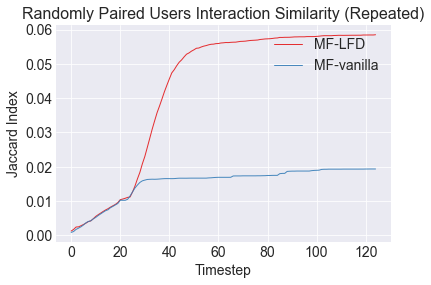

In [16]:
plot_metric(df1=mflfd_metrics, df2=mf_metrics, model1_lab='MF-LFD', model2_lab='MF-vanilla', 
            metric_var='interaction_similarity', ylab="Jaccard Index", 
            title="Randomly Paired Users Interaction Similarity (Repeated)")

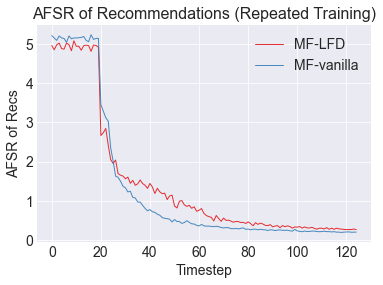

In [17]:
plot_metric(df1=mflfd_metrics, df2=mf_metrics, model1_lab='MF-LFD', model2_lab='MF-vanilla', 
            metric_var='afsr', ylab="AFSR of Recs", 
            title="AFSR of Recommendations (Repeated Training)")

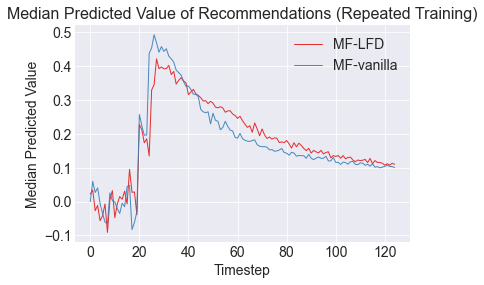

In [18]:
plot_metric(df1=mflfd_metrics, df2=mf_metrics, model1_lab='MF-LFD', model2_lab='MF-vanilla', 
            metric_var='shown_median_prediction', ylab="Median Predicted Value", 
            title="Median Predicted Value of Recommendations (Repeated Training)")

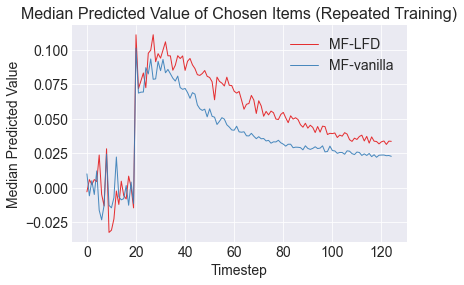

In [19]:
plot_metric(df1=mflfd_metrics, df2=mf_metrics, model1_lab='MF-LFD', model2_lab='MF-vanilla', 
            metric_var='interacted_median_prediction', ylab="Median Predicted Value", 
            title="Median Predicted Value of Chosen Items (Repeated Training)")

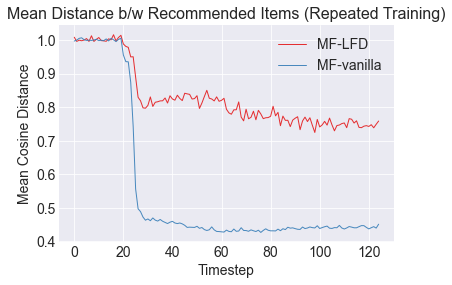

In [20]:
plot_metric(df1=mflfd_metrics, df2=mf_metrics, model1_lab='MF-LFD', model2_lab='MF-vanilla', 
            metric_var='mean_rec_distance', ylab="Mean Cosine Distance", 
            title="Mean Distance b/w Recommended Items (Repeated Training)")

In [ ]:
mf.predicted_scores.value[0].shape

In [ ]:
# mf_mean = np.mean(mf.predicted_scores.value, axis=0)
# plt.hist(mf_mean)
# plt.show()

# lfd_mean = np.mean(mflfd.predicted_scores.value, axis=0)
# plt.hist(lfd_mean)
# plt.show()

# plt.figure(figsize=(15, 15))
# plt.scatter(np.array(mf.predicted_scores.value).flatten(), mf.actual_user_item_scores.flatten())
# plt.xlabel("Predicted Scores")
# plt.ylabel("Actual Scores")

In [ ]:
mlsmall = MovieLens('../../MovieLens/data/ml-latest-small')
ratings=mlsmall.ratings

#make some fake interactions based on the ratings data
ratings["interaction"]=np.where(ratings["rating"]>=4, 1, 0)
ratings=ratings[ratings["interaction"]==1]
ratings = ratings[['user', 'item']]

algo_als = als.ImplicitMF(10, iterations=100)
algo_als.fit(ratings)
preds_als = batch.predict(algo_als, mlsmall.ratings)
#preds_als = pd.merge(preds_als, mlsmall.ratings, on=['user', 'item'])

preds_als.head(20)

In [ ]:
#preds_als.head(30)

plt.figure(figsize=(5, 5))
plt.scatter(preds_als["prediction"], preds_als["rating"], s=1)
plt.xlabel("Predicted Interaction Scores")
plt.ylabel("Actual Rating Scores")

In [ ]:
als_item_features = pd.DataFrame(als.item_features_)
mflfd_item_features = pd.DataFrame(mflfd.items_hat.T)
#mflfd_item_features.head()

mf_item_features = pd.DataFrame(mf.items_hat.T)
#mf_item_features.head()

In [ ]:
def plot_hist_features(features_df, model_type, color='blue'):
    font = {'family' : 'normal',
            'weight' : 'bold',
            'size'   : 12}

    plt.rc('font', **font)

    n_features = list(range(0,10))
    fig, axs = plt.subplots(math.ceil(len(n_features)/3), 3, figsize=(20,20))
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                        wspace=0.35)
    fig.suptitle('Latent Factors for {}'.format(model_type), size=20)

    for idx, n_feature in enumerate(n_features):
        r=idx //3
        c=idx % 3

        #hat = features_df[n_feature].tolist()
        features = features_df[n_feature].tolist()
        axs[r, c].set_title('Factor {}'.format(n_feature))

        #axs[r,c].plot(hat, actual, 'o', color=color);
        axs[r,c].hist(features, color=color)

    #for ax in axs.flat:
    #    ax.set(xlabel='hat representation', ylabel='actual representation')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    #for ax in axs.flat:
    #    ax.label_outer()

    fig.delaxes(axs[3][1])
    fig.delaxes(axs[3][2])

In [ ]:
plot_hist_features(als_item_features, 'MovieLens MF')

In [ ]:
plot_hist_features(mflfd_item_features, 'MF-LFD', 'red')

In [ ]:
plot_hist_features(mf_item_features, 'MF', 'green')

In [ ]:
mflfd

In [ ]:
mflfd.predicted_scores.value.shape

In [ ]:
median_predicted_std = np.std(predicted_rec_vals)
median_predicted_std

In [ ]:
# user_representation = Generator().binomial(
#     n=1, p=.3, size=(NUM_USERS, N_FACTORS)
# )

# item_representation = Generator().binomial(
#     n=1, p=.3, size=(N_FACTORS, NUM_ITEMS)
# )
# # Initialize with custom representations
# filtering = ContentFiltering(user_representation=user_representation,
#                             item_representation=item_representation)

# filtering.add_metrics(AverageFeatureScoreRange())
# filtering.run(10)

# filtering.get_measurements()
#u = ChaneyUsers(np.copy(known_scores), size=(NUM_USERS, NUM_ATTRS), num_users=NUM_USERS, attention_exp=ATTENTION_EXP, repeat_items=False)

In [ ]:
recommended_item_predictions = mflfd.predicted_scores.value[:, mflfd.rec]
recommended_item_predictions.shape

In [ ]:
mf.all_interactions.sort_values('user').head()

In [ ]:
mf_test = ImplicitMF(num_users=10, num_items=100, num_latent_factors=N_FACTORS, num_items_per_iter=10,
                model_params=model_params)
#mf.add_metrics(MSEMeasurement())
#mf.add_metrics(AverageFeatureScoreRange())
#mf.add_metrics(RecSimilarity(pairs=js_pairs))
mf_test.add_metrics(ShownMedianPrediction())
mf_test.add_metrics(InteractedMedianPrediction())
mf_test.add_metrics(MeanRecDistance())
mf_test.add_state_variable(mf.predicted_scores)
#mf_test.add_state_variable(mf.users.actual_user_scores)
mf_test.startup_and_train(NUM_STARTUP)
mf_test.run(timesteps=NUM_STEPS, train_between_steps=True, reset_interactions=False)
#mf.run(timesteps=NUM_STEPS)

In [ ]:
mf_test_metrics = pd.DataFrame(mf_test.get_measurements())
mf_test_metrics.head(30)

In [ ]:
# mf_scores = pd.DataFrame(mf.predicted_scores.value)
# cols = [f"item_{c}" for c in mf_scores.columns]
# mf_scores.columns = cols
# #mf_scores.head()
# mf_scores["user"] = list(range(mf_scores.shape[0]))


# # t=pd.wide_to_long(mf_scores, "item_", i="user", j="item").reset_index()
# # t.columns = ["user", "item", "predicted_score"]

In [ ]:
final_step_len = len(str(NUM_STEPS + NUM_STARTUP))

for t in range(NUM_STEPS + NUM_STARTUP):

    X=mf.predicted_scores.state_history[t].flatten()
    Y=mf.users.actual_user_scores.state_history[t].flatten()

    # plt.scatter(X, Y)
    # plt.figure(figsize=(15, 15))

    fig, ax = plt.subplots(figsize=(10,10))
    fig.set_tight_layout(True)
    ax.set(xlim=(-5, 5), ylim=(-5, 5))
    ax.set_xlabel("Predicted Score")
    ax.set_ylabel("Actual Score")
    ax.scatter(X,Y, s=1, alpha=.7)
    
    step_len=len(str(t))
    
    num_leading_zeros = final_step_len-step_len
    
    ext=str('0'*num_leading_zeros) + str(t)
    
    
    
    
    
    # Save it & close the figure
    filename='/Users/amywinecoff/Documents/CITP/Research/Github/scatters/mf/scatter_step'+ext+'.png'
    plt.savefig(fname=filename, dpi=96)
    plt.gca()
    plt.close(fig)


os.chdir('/Users/amywinecoff/Documents/CITP/Research/Github/scatters/mf')


In [ ]:
!convert -delay 20 scatter*.png animated_scatter_mf.gif
